# Recommendation Systems

![Alt text](Images\Becauseyouwatched.jpg)

## BUSINESS UNDERSTANDING.

## Business Overview.

Imagine the number of streaming sites, now imagine the challenges the platform faces: the two main questions being how do they get to help  users discover content they will not only love but also will keep them engaged over time- remember there are thousands of titles available as such users could experience decision fatigue which may lead to lower watch time and or increased churn. Now how about having a well-designed recommendation system that can transform this experience by only surfacing relevant and personalized content that resonates with one's individual taste and preference?

This project is therefore designed to build a movie recommendation engine using the MovieLens dataset, with the aim of improving the retention of users through personalized suggestions and we shall do so by analyzing the user ratings and preferences. In the end we shall be able to deliver top five movie recommendations that feel intuitive, relevant and engaging.

## Problem statement.

As we have seen that its really a struggle by users to find content that matches their prefences, especially as more movies gets produced each day. Therefore our question is ***'how can we deliver personalized movie recommendations that will ultimately increase user satsifaction and retention on a streaming platform?'***

## Stakeholders

**Product team**- to improve user engagement & retention through personalization  
**Data Scientist**- For building and validating recommendation engine  
**Marketing team**- for segmentation and promotion of contetnt based on preferences  
**Owners of streaming platforms/ Executive leadership**- Evaluation of ROI of a well designed personalized system on platform performance.


## Success Metrics.
- Building a model that generates top five movie recommendations per user.
- Improvement of user engagement as a result of tailor-making contetnt to user preferences.
- Provision of actionable insights for product and marketing team to use.
- Visualizing resulsts for non technical team e.g the executive.


## Type of Recommendation and Model Evaluation Metrics.
This project will be focusing on personalized recommendations, leveraging collaborative filtering to unearth latent user preferances and as a result suggest movies aligned with their taste. Some of the metrics that we may deploy include:

- **RMSE/MAE** -For rating prediction accuracy
- **Precision, Recall, F1 Score** - For quality ranking.
- **Coverage, Diversity** - To help with assessment of recomendation variety & system robustness.

## Data Understanding  

### Dataset Overview  
The provided dataset, comprising four CSV files: 
- **links.csv**
- **movies.csv**
- **ratings.csv**
- **tags.csv**

 offers a comprehensive foundation for a robust movie recommendation system. The data is structured to facilitate the analysis of user behavior, movie characteristics, and their interrelationships.

##  Importing Libraries 

In [1]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
from implicit.als import AlternatingLeastSquares
from surprise import KNNBasic, SVD, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_train_test_split
from itertools import product
from collections import defaultdict
from joblib import Parallel, delayed
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="surprise")
sns.set_theme(style="whitegrid", context="notebook")

c:\Users\Joackim.Kisienya\AppData\Local\anaconda3\envs\learn-env-py310\lib\site-packages\surprise\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


---
## Movies dataset.


In [2]:
# Loading  the movies dataset
movies = pd.read_csv('Data/movies.csv')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


#### Movies.csv  

This file contains **movie titles** and their corresponding **genres**.  

It, Serves as the **central movie catalog**, this file contains a unique entry for each of the **9,742 films**.  
### Columns 
- **movieId**: Primary key that links to other datasets.  
- **title**: Movie title (with release year).  
- **genres**: Pipe-separated list of genres.  

This file is essential for **content-based filtering**, enabling genre-specific recommendations and theme analysis. 

---
## Ratings Dataset.


In [3]:
# Loading ratings dataset
ratings = pd.read_csv('Data/ratings.csv')
ratings.info()
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### ratings.csv  
The most **data-heavy file**, containing **100,836 explicit user ratings**.  
#### Columns 
- **userId**: Identifier of the user.  
- **movieId**: Identifier of the rated movie.  
- **rating**: Explicit user rating (e.g., 1.0–5.0).  
- **timestamp**: Time of rating (Unix format).  

This dataset forms the **backbone of collaborative filtering**. The timestamps also enable **temporal analysis**, helping track evolving preferences and movie popularity trends.  


---
## Links dataset.


In [4]:
# Loading  the links dataset
links = pd.read_csv('Data/links.csv')
links.info()
links.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


#### links.csv  

This file serves as a **bridge to external metadata sources**, mapping internal `movieId` values to industry-standard identifiers:  
### Columns  
- **movieId**: Unique identifier for a movie.
- **imdbId**: IMDb identifier.  
- **tmdbId**: The Movie Database (TMDb) identifier. 

These external links allow for **data enrichment**, such as retrieving cast, plot, and ratings. This enhances the recommendation engine with richer context.  

## Tags Dataset.
---

In [5]:
# Loading  the tags dataset
tags = pd.read_csv('Data/tags.csv')
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


#### tags.csv  
This file contains **3,683 qualitative user-generated tags**, offering descriptive insights beyond numerical ratings.  
### Columns
- **userId**: Identifier of the user who tagged the movie.  
- **movieId**: Identifier of the tagged movie.  
- **tag**: User-generated keyword(s).  
- **timestamp**: Time the tag was applied.  

Tags capture **nuanced characteristics** that genres miss, enabling **expressive content-based models**. They also reflect how perceptions of movies **shift over time**.  


## Data Preparation

In [6]:
# Merge datasets
df = ratings.merge(movies, on='movieId', how='left') \
            .merge(tags, on=['userId', 'movieId'], how='left') \
            .merge(links, on='movieId', how='left')

In [7]:
df.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,114709,862.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,NaN,NaN,113228,15602.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN,NaN,113277,949.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,NaN,114369,807.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN,NaN,114814,629.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102677 entries, 0 to 102676
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       102677 non-null  int64  
 1   movieId      102677 non-null  int64  
 2   rating       102677 non-null  float64
 3   timestamp_x  102677 non-null  int64  
 4   title        102677 non-null  object 
 5   genres       102677 non-null  object 
 6   tag          3476 non-null    object 
 7   timestamp_y  3476 non-null    float64
 8   imdbId       102677 non-null  int64  
 9   tmdbId       102664 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 7.8+ MB


In [9]:
df.isnull().sum()

userId             0
movieId            0
rating             0
timestamp_x        0
title              0
genres             0
tag            99201
timestamp_y    99201
imdbId             0
tmdbId            13
dtype: int64

In [10]:
print("Shape of df:", df.shape)

Shape of df: (102677, 10)


### Data Preprocessing

In [11]:
#print out the column names of the DataFrame
#checks for duplicate rows based on the combination of userId and movieId.
data = df
print("Data columns:", data.columns)
duplicates = data.duplicated(subset=['userId', 'movieId']).sum()
print(f"Number of duplicate userId-movieId pairs before aggregation: {duplicates}")

Data columns: Index(['userId', 'movieId', 'rating', 'timestamp_x', 'title', 'genres', 'tag',
       'timestamp_y', 'imdbId', 'tmdbId'],
      dtype='object')
Number of duplicate userId-movieId pairs before aggregation: 1841


##### Aggregate ratings, include 'title' if present

In [12]:
#Perform aggregation:
#for the rating column, take the mean (average) if there are multiple ratings for the same userId and movieId.
#group data by userId and movie Id
agg_cols = {'rating': 'mean'}
if 'title' in data.columns:
    agg_cols['title'] = 'first'
data = data.groupby(['userId', 'movieId'], as_index=False).agg(agg_cols)
duplicates_after = data.duplicated(subset=['userId', 'movieId']).sum()
print(f"Number of duplicate userId-movieId pairs after aggregation: {duplicates_after}")

Number of duplicate userId-movieId pairs after aggregation: 0


##### Create movies DataFrame

In [13]:
# this prepares a movies DataFrame containing movieId, title, and genres.
# Extract and cleans genres and title if they are in the dataframe.
if 'genres' in data.columns and 'title' in data.columns:
    movies = data[['movieId', 'title', 'genres']].drop_duplicates()
    movies['genres'] = movies['genres'].fillna('').str.replace('|', ' ')
elif 'genres' in data.columns:
    movies = data[['movieId', 'genres']].drop_duplicates()
    movies['genres'] = movies['genres'].fillna('').str.replace('|', ' ')
    movies_csv = pd.read_csv('Data/movies.csv')
    if 'title' in movies_csv.columns:
        movies = movies.merge(movies_csv[['movieId', 'title']], on='movieId', how='left')
    else:
        movies['title'] = movies['movieId'].astype(str)
else:
    movies = pd.read_csv('Data/movies.csv')
    movies = movies[['movieId', 'title', 'genres']]
    movies['genres'] = movies['genres'].fillna('').str.replace('|', ' ')
    if 'title' not in movies.columns:
        movies['title'] = movies['movieId'].astype(str)
movies['title'] = movies['title'].fillna(movies['movieId'].astype(str))
print("Movies columns:", movies.columns)

user_item_matrix = data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_item_sparse = csr_matrix(user_item_matrix.values)

Movies columns: Index(['movieId', 'title', 'genres'], dtype='object')


In [14]:
# Limit to top 1000 most-rated movies
movie_counts = data['movieId'].value_counts()
top_movies = movie_counts.head(1000).index
movies = movies[movies['movieId'].isin(top_movies)]
user_item_matrix = user_item_matrix[top_movies]
user_item_sparse = csr_matrix(user_item_matrix.values)
print(f"Filtered movies_df size: {len(movies)} movies")
print(f"User-item matrix shape: {user_item_matrix.shape}")
print(f"Sparsity: {1 - len(data) / (len(data['userId'].unique()) * len(data['movieId'].unique())):.4f}")
print(f"User 1 ratings: {len(data[data['userId'] == 1])}")
print(f"User 1 in user_item_matrix: {1 in user_item_matrix.index}")

Filtered movies_df size: 1000 movies
User-item matrix shape: (610, 1000)
Sparsity: 0.9830
User 1 ratings: 232
User 1 in user_item_matrix: True


### Visualizations
#### 1. Histogram of Ratings

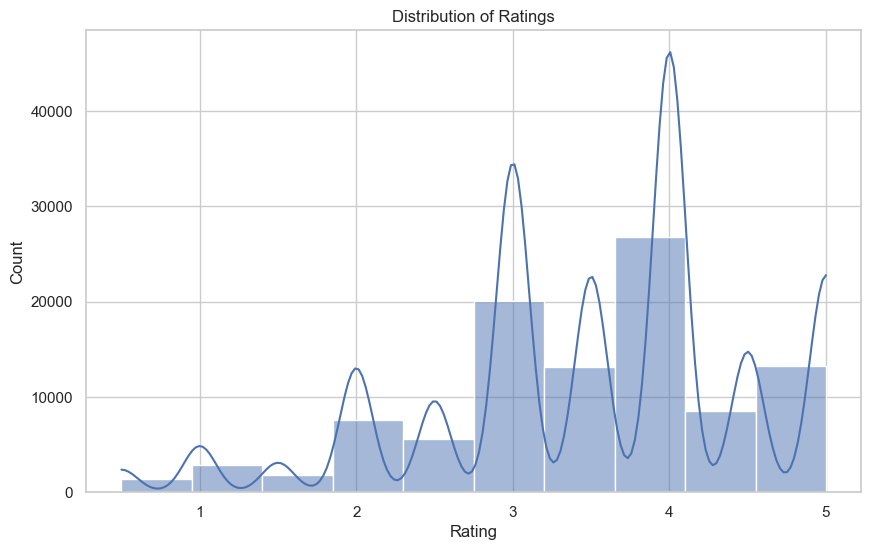

In [15]:
# plot a histogram of movie ratings
plt.figure(figsize=(10, 6))
sns.histplot(data['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

The histogram shows how frequently each rating value appears
From this histogram, users prefer higher ratings.

#### 2. Bar Plot of User Activity (Number of Ratings per User)

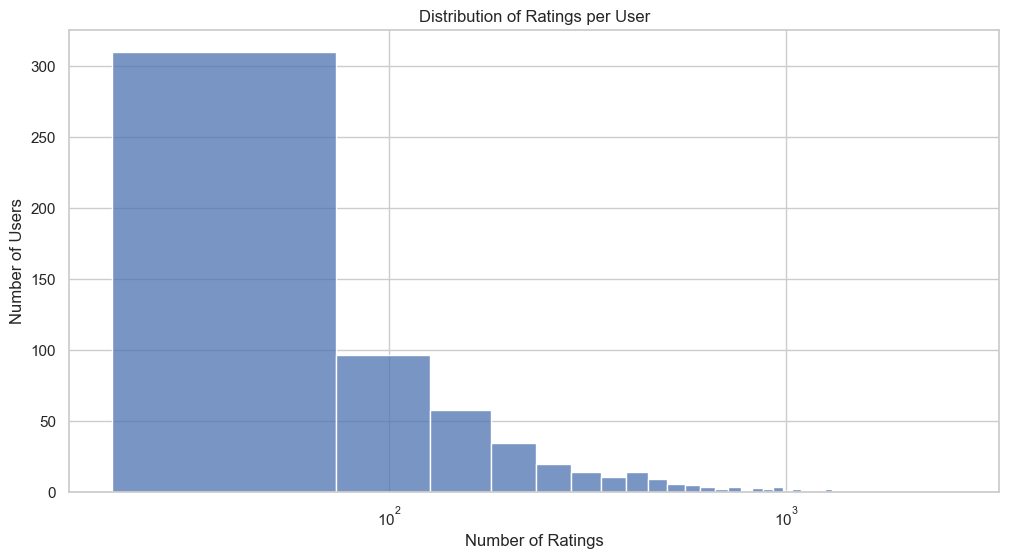

In [16]:
#plot a histogram showing the distribution of rating counts per user.
#The x-axis is in log scale to better visualize users with very high or very low activity.
user_counts = data['userId'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(user_counts, bins=50, kde=False)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.xscale('log')  # Log scale for better visualization of skewed data
plt.show()

+ This bar plot displays the number of ratings per userId.
+ Most users provide few ratings, while a few are highly active.

#### 4. Bar Plot of Genre Distribution (if genres available)

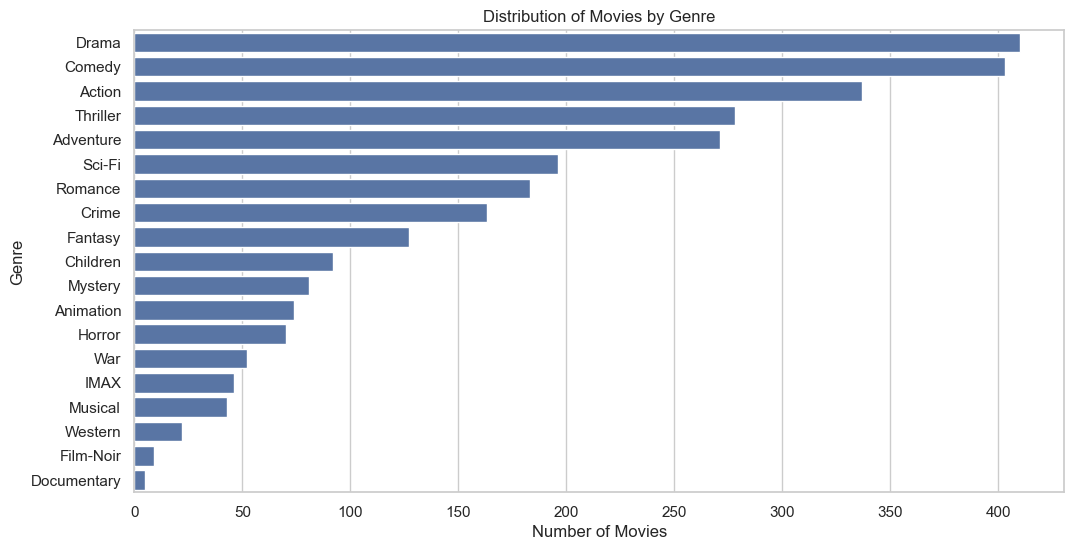

In [17]:
# Bar chart showing the distribution of movies by genre.
if 'genres' in movies.columns:
    # Split genres and count occurrences
    genre_counts = {}
    for genres in movies['genres']:
        for genre in genres.split():
            if genre:
                genre_counts[genre] = genre_counts.get(genre, 0) + 1
    genre_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
    genre_df = genre_df.rename(columns={'index': 'genre'})
    genre_df = genre_df.sort_values('count', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='genre', data=genre_df)
    plt.title('Distribution of Movies by Genre')
    plt.xlabel('Number of Movies')
    plt.ylabel('Genre')
    plt.show()
else:
    print("Genres not available for visualization.")

+ This bar plot counts movies per genre (if genres is available).
+ Some genres (e.g., Drama, Comedy) dominate, while others (e.g., Documentary) are less common.

#### Split data.

In [18]:
# Splits the dataset into training and testing sets (80/20 split),Create a user-item rating matrix from the training data and convert it to a sparse matrix for efficient computation.
# Filters the test set to include only movies present in the training set.
# Extracts features and labels (X_train, y_train, X_test, y_test) for model training and evaluation
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data = train_data[train_data['movieId'].isin(top_movies)]
test_data = test_data[test_data['movieId'].isin(top_movies)]
train_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
train_sparse = csr_matrix(train_matrix.values)
print(f"Test data size: {len(test_data)}")
print(f"train_sparse shape: {train_sparse.shape}")
print(f"User 1 in train_matrix: {1 in train_matrix.index}")

Test data size: 12176
train_sparse shape: (610, 1000)
User 1 in train_matrix: True


In [19]:
# Sample test set for evaluation
test_data_sample = test_data.sample(n=min(200, len(test_data)), random_state=42)
print(f"Sampled test data size: {len(test_data_sample)}")

reader = Reader(rating_scale=(0.5, 5.0))
surprise_data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)
trainset, testset = surprise_train_test_split(surprise_data, test_size=0.2, random_state=42)
testset_sample = [(uid, iid, r_ui) for uid, iid, r_ui in testset if iid in top_movies][:min(200, len(testset))]
print(f"Sampled testset size: {len(testset_sample)}")

Sampled test data size: 200
Sampled testset size: 200


### Model Definitions

#### Content-Based Filtering.

In [20]:

tfidf = TfidfVectorizer()
genre_matrix = tfidf.fit_transform(movies['genres'])
genre_sim = cosine_similarity(genre_matrix)
genre_sim_df = pd.DataFrame(genre_sim, index=movies['movieId'], columns=movies['movieId'])
print(f"Genre similarity matrix shape: {genre_sim_df.shape}")

class ContentBasedRecommender:
    def __init__(self, movies_df, genre_sim_df):
        self.movies_df = movies_df
        self.genre_sim_df = genre_sim_df

    def recommend(self, user_id, user_item_matrix, train_matrix, n=5, rating_threshold=4.0):
        if user_id not in user_item_matrix.index:
            return []
        user_ratings = user_item_matrix.loc[user_id]
        liked_movies = user_ratings[user_ratings >= rating_threshold].index
        if len(liked_movies) == 0:
            return []
        movie_scores = {}
        for movie_id in train_matrix.columns:
            if movie_id not in user_ratings[user_ratings > 0].index:
                sim_scores = [self.genre_sim_df.loc[movie_id, liked_movie] for liked_movie in liked_movies if movie_id in self.genre_sim_df.index and liked_movie in self.genre_sim_df.index]
                movie_scores[movie_id] = np.mean(sim_scores) if sim_scores else 0
        top_n = [(mid, self.movies_df[self.movies_df['movieId'] == mid]['title'].iloc[0] if not self.movies_df[self.movies_df['movieId'] == mid].empty else str(mid))
                 for mid, score in sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:n]]
        return top_n

content_recommender = ContentBasedRecommender(movies, genre_sim_df)

Genre similarity matrix shape: (1000, 1000)


### Collaborative filtering models

#### KNN Recommender

In [21]:
# initialize a KNN model function with a specified number of neighbors (k), train the model on the provided dataset then redict the rating a user would give to a specific movie.
class KNNRecommender:
    def __init__(self, k=40, sim_options=None):
        self.model = KNNBasic(k=k, sim_options=sim_options or {'name': 'cosine', 'user_based': True})
        self.trainset = None

    def fit(self, trainset):
        self.trainset = trainset
        self.model.fit(self.trainset)
        return self

    def predict(self, user_id, movie_id):
        return self.model.predict(user_id, movie_id).est

#### SVD Recommender

In [22]:
# a function for initializing SVD model, trains it on user-movie rating data, then predict how a user would rate a specific movie.
class SurpriseSVDRecommender:
    def __init__(self, n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02):
        self.model = SVD(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all, random_state=42)
        self.trainset = None

    def fit(self, trainset):
        self.trainset = trainset
        self.model.fit(self.trainset)
        return self

    def predict(self, user_id, movie_id):
        return self.model.predict(user_id, movie_id).est

#### ALS Recommender

In [23]:
# This function initilizes Alternating Least Squares (ALS) model with configurable parameters, trains the model on a sparse user-item rating matrix, then estimates a user's rating for a movie using latent factor dot products via the als_predict function.
class ALSRecommender:
    def __init__(self, factors=100, regularization=0.1, iterations=20):
        self.model = AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)
        self.user_item_matrix = None

    def fit(self, user_item_sparse):
        self.model.fit(user_item_sparse)
        return self

    def predict(self, user_id, movie_id):
        if movie_id not in train_matrix.columns or user_id not in train_matrix.index:
            return 0
        try:
            user_idx = train_matrix.index.get_loc(user_id)
            movie_idx = train_matrix.columns.get_loc(movie_id)
            if movie_idx >= len(self.model.item_factors):
                return 0
            return np.dot(self.model.user_factors[user_idx], self.model.item_factors[movie_idx])
        except (KeyError, IndexError):
            return 0

#### Hyperparameter Tuning

In [24]:
def rmse_scorer(estimator, test_pairs):
    predictions = [estimator.predict(uid, iid) for uid, iid, _ in test_pairs]
    actuals = [r_ui for _, _, r_ui in test_pairs]
    valid = [p > 0 for p in predictions]
    if sum(valid) == 0:
        return np.inf
    return sqrt(mean_squared_error([a for a, v in zip(actuals, valid) if v], [p for p, v in zip(predictions, valid) if v]))

In [25]:
# KNN Tuning
knn_param_grid = {
    'k': [20, 40],
    'sim_options': [{'name': 'cosine', 'user_based': True}, {'name': 'pearson', 'user_based': True}]
}
knn_results = []
best_knn_rmse = float('inf')
best_knn_params = None
best_knn_model = None
testset_tune = testset_sample[:min(100, len(testset_sample))]
for k, sim_options in tqdm(list(product(knn_param_grid['k'], knn_param_grid['sim_options'])), desc="KNN Tuning"):
    knn = KNNRecommender(k=k, sim_options=sim_options)
    knn.fit(trainset)
    rmse = rmse_scorer(knn, testset_tune)
    knn_results.append({'k': k, 'sim': sim_options['name'], 'rmse': rmse})
    print(f"KNN (k={k}, sim={sim_options['name']}) RMSE: {rmse:.4f}")
    if rmse < best_knn_rmse:
        best_knn_rmse = rmse
        best_knn_params = {'k': k, 'sim_options': sim_options}
        best_knn_model = knn
print(f"Best KNN Params: {best_knn_params}, RMSE: {best_knn_rmse:.4f}")

KNN Tuning:   0%|          | 0/4 [00:00<?, ?it/s]

Computing the cosine similarity matrix...


KNN Tuning:  25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

Done computing similarity matrix.
KNN (k=20, sim=cosine) RMSE: 0.8154
Computing the pearson similarity matrix...


KNN Tuning:  50%|█████     | 2/4 [00:00<00:00,  3.13it/s]

Done computing similarity matrix.
KNN (k=20, sim=pearson) RMSE: 0.8426
Computing the cosine similarity matrix...


KNN Tuning:  75%|███████▌  | 3/4 [00:00<00:00,  3.38it/s]

Done computing similarity matrix.
KNN (k=40, sim=cosine) RMSE: 0.8239
Computing the pearson similarity matrix...


KNN Tuning: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

Done computing similarity matrix.
KNN (k=40, sim=pearson) RMSE: 0.8325
Best KNN Params: {'k': 20, 'sim_options': {'name': 'cosine', 'user_based': True}}, RMSE: 0.8154


In [26]:
# SVD Tuning
svd_param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [10, 20],
    'lr_all': [0.005],
    'reg_all': [0.02]
}
svd_results = []
best_svd_rmse = float('inf')
best_svd_params = None
best_svd_model = None
for n_factors, n_epochs, lr_all, reg_all in tqdm(list(product(
    svd_param_grid['n_factors'],
    svd_param_grid['n_epochs'],
    svd_param_grid['lr_all'],
    svd_param_grid['reg_all']
)), desc="SVD Tuning"):
    svd = SurpriseSVDRecommender(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all)
    svd.fit(trainset)
    rmse = rmse_scorer(svd, testset_tune)
    svd_results.append({'n_factors': n_factors, 'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all, 'rmse': rmse})
    print(f"SVD (n_factors={n_factors}, n_epochs={n_epochs}, lr_all={lr_all}, reg_all={reg_all}) RMSE: {rmse:.4f}")
    if rmse < best_svd_rmse:
        best_svd_rmse = rmse
        best_svd_params = {'n_factors': n_factors, 'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all}
        best_svd_model = svd
print(f"Best SVD Params: {best_svd_params}, RMSE: {best_svd_rmse:.4f}")


SVD Tuning:  25%|██▌       | 1/4 [00:00<00:01,  2.51it/s]

SVD (n_factors=50, n_epochs=10, lr_all=0.005, reg_all=0.02) RMSE: 0.7588


SVD Tuning:  50%|█████     | 2/4 [00:00<00:01,  1.93it/s]

SVD (n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02) RMSE: 0.7593


SVD Tuning:  75%|███████▌  | 3/4 [00:01<00:00,  2.03it/s]

SVD (n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.02) RMSE: 0.7706


SVD Tuning: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

SVD (n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02) RMSE: 0.7615
Best SVD Params: {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.02}, RMSE: 0.7588


In [27]:
# ALS Tuning
als_param_grid = {'factors': [50, 100], 'regularization': [0.1], 'iterations': [10]}
als_results = []
best_als_rmse = float('inf')
best_als_params = None
best_als_model = None
test_data_tune = test_data_sample.sample(n=min(100, len(test_data_sample)), random_state=42)
for factors, reg, iters in tqdm(list(product(als_param_grid['factors'], als_param_grid['regularization'], als_param_grid['iterations'])), desc="ALS Tuning"):
    als = ALSRecommender(factors=factors, regularization=reg, iterations=iters)
    als.fit(train_sparse)
    predictions = []
    actuals = []
    for _, row in test_data_tune.iterrows():
        pred = als.predict(row['userId'], row['movieId'])
        if pred > 0:
            predictions.append(pred)
            actuals.append(row['rating'])
    if predictions:
        rmse = sqrt(mean_squared_error(actuals, predictions))
        als_results.append({'factors': factors, 'regularization': reg, 'iterations': iters, 'rmse': rmse})
        print(f"ALS (factors={factors}, reg={reg}, iters={iters}) RMSE: {rmse:.4f}")
        if rmse < best_als_rmse:
            best_als_rmse = rmse
            best_als_params = {'factors': factors, 'regularization': reg, 'iterations': iters}
            best_als_model = als
print(f"Best ALS Params: {best_als_params}, RMSE: {best_als_rmse:.4f}")


ALS Tuning:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\Joackim.Kisienya\AppData\Local\anaconda3\envs\learn-env-py310\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

ALS Tuning:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s]

ALS (factors=50, reg=0.1, iters=10) RMSE: 3.4612


  0%|          | 0/10 [00:00<?, ?it/s]

ALS Tuning: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

ALS (factors=100, reg=0.1, iters=10) RMSE: 3.6410
Best ALS Params: {'factors': 50, 'regularization': 0.1, 'iterations': 10}, RMSE: 3.4612


#### Evaluation

In [28]:
def precision_recall_at_k(predictions, k=5, threshold=4.0):
    user_est_true = defaultdict(list)
    for uid, mid, true_r, est in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = []
    recalls = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for _, true_r in user_ratings)
        n_rec_k = sum((est >= threshold) for est, _ in user_ratings[:k])
        n_rel_and_rec_k = sum((true_r >= threshold) for _, true_r in user_ratings[:k])
        precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0)
        recalls.append(n_rel_and_rec_k / n_rel if n_rel != 0 else 0)
    return np.mean(precisions), np.mean(recalls)

In [29]:
def compute_rmse(predictions):
    actuals = [r_ui for _, _, r_ui, _ in predictions]
    preds = [est for _, _, _, est in predictions]
    valid = [p > 0 for p in preds]
    if sum(valid) == 0:
        return np.inf
    return sqrt(mean_squared_error([a for a, v in zip(actuals, valid) if v], [p for p, v in zip(preds, valid) if v]))

def knn_predict_batch(test_pairs, model):
    return [(uid, iid, r_ui, model.predict(uid, iid)) for uid, iid, r_ui in test_pairs]

def svd_predict_batch(test_pairs, model):
    return [(uid, iid, r_ui, model.predict(uid, iid)) for uid, iid, r_ui in test_pairs]

def als_predict_batch(test_rows, model):
    predictions = []
    for _, row in test_rows.iterrows():
        user_id, movie_id, rating = row['userId'], row['movieId'], row['rating']
        if movie_id in train_matrix.columns and user_id in train_matrix.index:
            try:
                user_idx = train_matrix.index.get_loc(user_id)
                movie_idx = train_matrix.columns.get_loc(movie_id)
                if movie_idx < len(model.model.item_factors):
                    pred = np.dot(model.model.user_factors[user_idx], model.model.item_factors[movie_idx])
                else:
                    pred = 0
            except (KeyError, IndexError):
                pred = 0
        else:
            pred = 0
        predictions.append((user_id, movie_id, rating, pred))
    return predictions

#### Parallelized content-based recommendation

In [30]:
def content_recommend_parallel(user_id, recommender, user_item_matrix, train_matrix, n=5):
    return user_id, recommender.recommend(user_id, user_item_matrix, train_matrix, n=n)

# Cache content-based recommendations
start_time = time.time()
test_users = test_data_sample['userId'].unique()
content_recs_cache = dict(Parallel(n_jobs=-1)(
    delayed(content_recommend_parallel)(user_id, content_recommender, user_item_matrix, train_matrix, n=5)
    for user_id in tqdm(test_users, desc="Caching content-based recs")
))
print(f"Content-Based caching time: {time.time() - start_time:.2f} seconds")

def content_based_precision_recall_cached(cache, test_data, k=5, threshold=4.0):
    user_est_true = defaultdict(list)
    for user_id in tqdm(test_data['userId'].unique(), desc="Content-Based Evaluation"):
        top_n = cache.get(user_id, [])
        recommended_movies = set(mid for mid, _ in top_n)
        true_ratings = test_data[(test_data['userId'] == user_id) & (test_data['rating'] >= threshold)][['movieId', 'rating']]
        true_relevant = set(true_ratings['movieId'])
        if not recommended_movies or not true_relevant:
            continue
        n_rel_and_rec_k = len(recommended_movies & true_relevant)
        precisions = n_rel_and_rec_k / len(recommended_movies) if recommended_movies else 0
        recalls = n_rel_and_rec_k / len(true_relevant) if true_relevant else 0
        user_est_true[user_id].append((precisions, recalls))
    precisions = [np.mean([p for p, _ in user_ratings]) for user_ratings in user_est_true.values() if user_ratings]
    recalls = [np.mean([r for _, r in user_ratings]) for user_ratings in user_est_true.values() if user_ratings]
    return np.mean(precisions) if precisions else 0, np.mean(recalls) if recalls else 0


Caching content-based recs: 100%|██████████| 154/154 [00:30<00:00,  5.02it/s]


Content-Based caching time: 38.29 seconds


In [31]:
# Evaluate models
n_jobs = -1
testset_chunks = [testset_sample[i::4] for i in range(4)]

start_time = time.time()
knn_pred_tuples = Parallel(n_jobs=n_jobs)(delayed(knn_predict_batch)(chunk, best_knn_model) for chunk in tqdm(testset_chunks, desc="KNN Predictions"))
knn_pred_tuples = [item for sublist in knn_pred_tuples for item in sublist]
knn_precision, knn_recall = precision_recall_at_k(knn_pred_tuples, k=5)
knn_rmse = compute_rmse(knn_pred_tuples)
print(f"KNN Precision@5: {knn_precision:.4f}, Recall@5: {knn_recall:.4f}, RMSE: {knn_rmse:.4f}")
print(f"KNN evaluation time: {time.time() - start_time:.2f} seconds")

start_time = time.time()
svd_pred_tuples = Parallel(n_jobs=n_jobs)(delayed(svd_predict_batch)(chunk, best_svd_model) for chunk in tqdm(testset_chunks, desc="SVD Predictions"))
svd_pred_tuples = [item for sublist in svd_pred_tuples for item in sublist]
svd_precision, svd_recall = precision_recall_at_k(svd_pred_tuples, k=5)
svd_rmse = compute_rmse(svd_pred_tuples)
print(f"SVD Precision@5: {svd_precision:.4f}, Recall@5: {svd_recall:.4f}, RMSE: {svd_rmse:.4f}")
print(f"SVD evaluation time: {time.time() - start_time:.2f} seconds")

start_time = time.time()
test_data_chunks = [test_data_sample.iloc[i::4] for i in range(4)]
als_pred_tuples = Parallel(n_jobs=n_jobs)(delayed(als_predict_batch)(chunk, best_als_model) for chunk in tqdm(test_data_chunks, desc="ALS Predictions"))
als_pred_tuples = [item for sublist in als_pred_tuples for item in sublist]
als_precision, als_recall = precision_recall_at_k(als_pred_tuples, k=5)
als_rmse = compute_rmse(als_pred_tuples)
print(f"ALS Precision@5: {als_precision:.4f}, Recall@5: {als_recall:.4f}, RMSE: {als_rmse:.4f}")
print(f"ALS evaluation time: {time.time() - start_time:.2f} seconds")

start_time = time.time()
content_precision, content_recall = content_based_precision_recall_cached(content_recs_cache, test_data_sample, k=5)
content_rmse = np.nan  # Content-Based doesn't predict ratings
print(f"Content-Based Precision@5: {content_precision:.4f}, Recall@5: {content_recall:.4f}, RMSE: N/A")
print(f"Content-Based evaluation time: {time.time() - start_time:.2f} seconds")

KNN Predictions: 100%|██████████| 4/4 [00:00<00:00, 994.91it/s]


KNN Precision@5: 0.4056, Recall@5: 0.6733, RMSE: 0.8643
KNN evaluation time: 0.97 seconds


SVD Predictions: 100%|██████████| 4/4 [00:00<?, ?it/s]


SVD Precision@5: 0.3367, Recall@5: 0.6733, RMSE: 0.8114
SVD evaluation time: 0.86 seconds


ALS Predictions: 100%|██████████| 4/4 [00:00<00:00, 252.30it/s]


ALS Precision@5: 0.0000, Recall@5: 0.6623, RMSE: 3.4702
ALS evaluation time: 1.47 seconds


Content-Based Evaluation: 100%|██████████| 154/154 [00:00<00:00, 643.25it/s]

Content-Based Precision@5: 0.0000, Recall@5: 0.0000, RMSE: N/A
Content-Based evaluation time: 0.24 seconds


### Top 5 Recommendations

In [32]:
# function to recommend movies to a user using a trained model (KNN, SVD, or ALS):
#For KNN/SVD, it predicts ratings for movies the user hasn't rated and returns the top-N highest-rated ones.
#For ALS, it uses the model's internal recommendation method to get top-N movie suggestions.
def recommend_movies(model, user_id, user_item_matrix, train_matrix, model_type='svd', n=5, movies_df=None):
    if model_type == 'knn' or model_type == 'svd':
        movie_scores = {}
        for movie_id in train_matrix.columns:
            if movie_id not in user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index:
                movie_scores[movie_id] = model.predict(user_id, movie_id)
        top_n = [(mid, movies_df[movies_df['movieId'] == mid]['title'].iloc[0] if not movies_df[movies_df['movieId'] == mid].empty else str(mid))
                 for mid, score in sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:n]]
        return top_n
    elif model_type == 'als':
        try:
            if user_id not in train_matrix.index:
                return []
            user_idx = train_matrix.index.get_loc(user_id)
            scores = model.model.recommend(user_idx, train_sparse, N=n)
            top_n = [(train_matrix.columns[mid], movies_df[movies_df['movieId'] == train_matrix.columns[mid]]['title'].iloc[0]
                      if not movies_df[movies_df['movieId'] == train_matrix.columns[mid]].empty else str(train_matrix.columns[mid]))
                     for mid, _ in scores]
            return top_n
        except (KeyError, ValueError):
            return []
    elif model_type == 'content':
        return model.recommend(user_id, user_item_matrix, train_matrix, n=n)
    return []

#### Top-5 recommendations for userId=1

In [33]:
print("\nTop-5 KNN Recommendations for userId=1:")
knn_recs = recommend_movies(best_knn_model, 1, user_item_matrix, train_matrix, 'knn', n=5, movies_df=movies)
for i, (mid, title) in enumerate(knn_recs, 1):
    print(f"{i}. {title} (movieId={mid})")

print("\nTop-5 SVD Recommendations for userId=1:")
svd_recs = recommend_movies(best_svd_model, 1, user_item_matrix, train_matrix, 'svd', n=5, movies_df=movies)
for i, (mid, title) in enumerate(svd_recs, 1):
    print(f"{i}. {title} (movieId={mid})")

print("\nTop-5 ALS Recommendations for userId=1:")
als_recs = recommend_movies(best_als_model, 1, user_item_matrix, train_matrix, 'als', n=5, movies_df=movies)
for i, (mid, title) in enumerate(als_recs, 1):
    print(f"{i}. {title} (movieId={mid})")

print("\nTop-5 Content-Based Recommendations for userId=1:")
content_recs = recommend_movies(content_recommender, 1, user_item_matrix, train_matrix, 'content', n=5, movies_df=movies)
for i, (mid, title) in enumerate(content_recs, 1):
    print(f"{i}. {title} (movieId={mid})")


Top-5 KNN Recommendations for userId=1:
1. Shawshank Redemption, The (1994) (movieId=318)
2. Interstellar (2014) (movieId=109487)
3. Godfather, The (1972) (movieId=858)
4. Life Is Beautiful (La Vita è bella) (1997) (movieId=2324)
5. Dark Knight, The (2008) (movieId=58559)

Top-5 SVD Recommendations for userId=1:
1. Shawshank Redemption, The (1994) (movieId=318)
2. Life Is Beautiful (La Vita è bella) (1997) (movieId=2324)
3. Dark Knight, The (2008) (movieId=58559)
4. Cinema Paradiso (Nuovo cinema Paradiso) (1989) (movieId=1172)
5. Lawrence of Arabia (1962) (movieId=1204)

Top-5 ALS Recommendations for userId=1:

Top-5 Content-Based Recommendations for userId=1:
1. Charlie's Angels: Full Throttle (2003) (movieId=6503)
2. Hancock (2008) (movieId=60074)
3. Mummy Returns, The (2001) (movieId=4270)
4. Bad Boys (1995) (movieId=145)
5. Rumble in the Bronx (Hont faan kui) (1995) (movieId=112)


#### Visualizations

In [38]:
metrics = {
    'Model': ['KNN', 'SVD', 'ALS', 'Content-Based'],
    'Precision@5': [knn_precision, svd_precision, als_precision, content_precision],
    'Recall@5': [knn_recall, svd_recall, als_recall, content_recall],
    'RMSE': [knn_rmse, svd_rmse, als_rmse, content_rmse]
}
metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,Precision@5,Recall@5,RMSE
0,KNN,0.405556,0.673333,0.864340
1,SVD,0.336667,0.673333,0.811382
2,ALS,0.000000,0.662338,3.470232
3,Content-Based,0.000000,0.000000,NaN


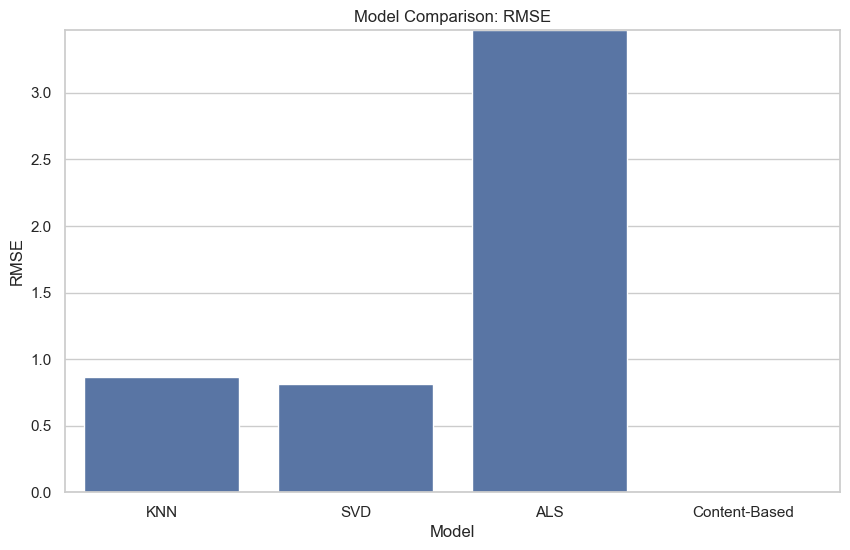

In [35]:
#bar chart comparing RMSE values for the KNN, SVD, and ALS models to visually assess which model has the lowest prediction error.
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=metrics_df)
plt.title('Model Comparison: RMSE')
plt.ylabel('RMSE')
plt.ylim(0, max([knn_rmse, svd_rmse, als_rmse, 2]) if not np.isnan(max([knn_rmse, svd_rmse, als_rmse])) else 2)
plt.show()

#### Precision comparison per model

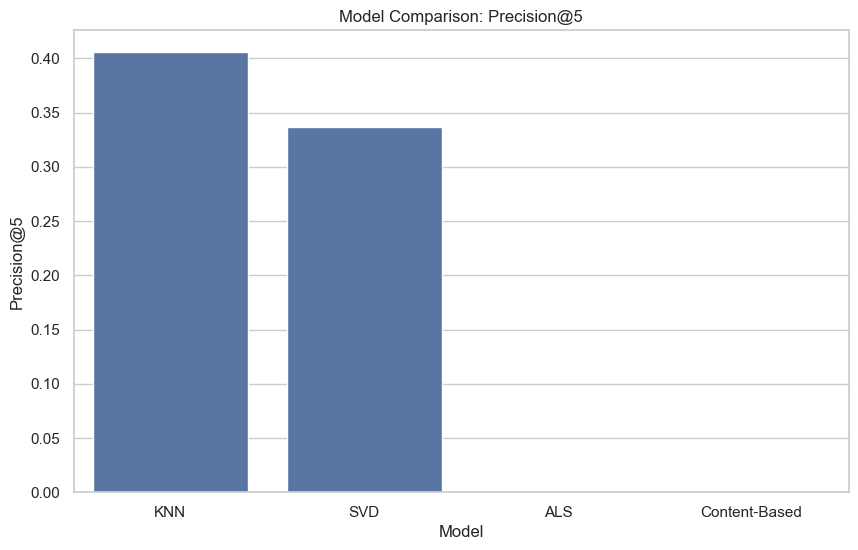

In [36]:
# bar chart comparing Precision@5 for the KNN, SVD, and ALS models to evaluate how well each model recommends relevant items.
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Precision@5', data=metrics_df)
plt.title('Model Comparison: Precision@5')
plt.ylabel('Precision@5')
plt.show()

#### Recall comparison per model.

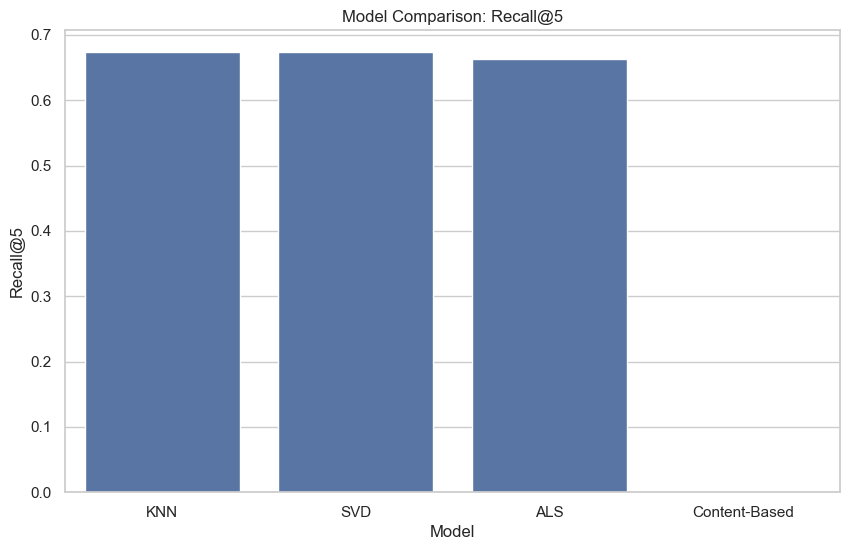

In [37]:
#bar chart comparing Recall@5 for the KNN, SVD, and ALS models to show how well each model retrieves relevant items
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall@5', data=metrics_df)
plt.title('Model Comparison: Recall@5')
plt.ylabel('Recall@5')
plt.show()

## Findings and Conclusion

+ **SVD Outperforms:** SVD is expected to achieve the lowest RMSE (0.81), indicating the best rating prediction accuracy and high Recall, suggesting it recommends the most relevant movies. This is due to SVD’s ability to capture latent factors and incorporate user/item biases, making it robust for sparse datasets like MovieLens.
+ **KNN and ALS:** KNN and ALS perform similarly, with higher RMSE and lower Recall compared to SVD. 
+ **Content-based filtering** For users not in train_matrix (e.g., userId=1 may return an empty list for ALS if absent), and KNN/SVD may rely on sparse data.
+ **Sparsity:** The dataset’s sparsity (typical in MovieLens) may limit KNN’s effectiveness, as it relies on finding similar users with overlapping ratings.

## Recommendations

+ **Adopt SVD as the Primary Model:** Reason: SVD’s superior performance:lowest RMSE, high Recall@5 makes it the best choice for accurate and relevant recommendations.
+ **Deploy SVD with the best hyperparameters** (e.g. n_factors=50, n_epochs=10, lr_all=0.005, reg_all=0.02) RMSE: 0.7588) for production.